In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
%matplotlib inline

In [2]:
powerplant_data_path = "../data/power_plants.csv"
air_data_path = "../data/air_concentrations.csv"

In [125]:
pp_df = pd.read_csv(powerplant_data_path)
air_df = pd.read_csv(air_data_path)

# pp_counties = set(pp_df['county'].unique())
# air_counties = set(air_df['county'].unique())
# overlap_counties = pp_counties & air_counties

# filter by overlapping counties
# pp_df = pp_df[pp_df['county'].isin(overlap_counties)]
# air_df = air_df[air_df['county'].isin(overlap_counties)]

pp_df['source_description'] = pp_df['source_description'].str.lower()
pp_df = pp_df.merge(pp_df['source_description'].str.split(',', expand=True), left_index=True, right_index=True)
pp_df = pp_df.reset_index()
pp_df = pp_df.drop('index', axis=1)

pp_df.head()

,longitude,latitude,plant_name,utility_name,sector_name,city,county,state_name,primary_source,total_power,source_description,tech_description,0,1,2,3,4
0,-87.356823,33.458665,Bankhead Dam,Alabama Power Co,Electric Utility,Northport,as,Alabama,hydroelectric,56.0,g,Conventional Hydroelectric,g,None,None,None,None
1,-88.010300,31.006900,Barry,Alabama Power Co,Electric Utility,Bucks,Mobile,Alabama,coal,2160.5,"coal = 1088.5 mw, natural gas = 1072 mw",Conventional Steam Coal; Natural Gas Fired Com...,coal = 1088.5 mw,natural gas = 1072 mw,None,None,None
2,-86.283056,32.583889,Walter Bouldin Dam,Alabama Power Co,Electric Utility,Wetumpka,Elmore,Alabama,hydroelectric,225.9,hydroelectric = 225.9 mw,Conventional Hydroelectric,hydroelectric = 225.9 mw,None,None,None,None
3,-85.970800,34.012800,Gadsden,Alabama Power Co,Electric Utility,Gadsden,Etowah,Alabama,natural gas,130.0,natural gas = 130 mw,Natural Gas Steam Turbine,natural gas = 130 mw,None,None,None,None
4,-87.196486,33.644344,Gorgas,Alabama Power Co,Electric Utility,Parrish,Walker,Alabama,coal,1034.0,coal = 1034 mw,Conventional Steam Coal,coal = 1034 mw,None,None,None,None


In [151]:
energy_sources = list(pp_df.primary_source.unique())
nongreen_sources = ['coal', 'natural gas', 'petroleum']
green_sources = ['hydroelectric', 'biomass', 'solar', 'wind', 'nuclear', 'pumped storage', 'geothermal']
energy_sources = nongreen_sources + green_sources

In [155]:
energy_sources

['coal',
 'natural gas',
 'petroleum',
 'hydroelectric',
 'biomass',
 'solar',
 'wind',
 'nuclear',
 'pumped storage',
 'geothermal']

In [152]:
def parse_power(df, power_type):
    def f(x):
        if x:
            return x[0]
        return 0
    
    print(power_type)
    x = df[0].str.contains(power_type).fillna(False) 
    series = (x * df[0].str.findall('(\d+.?\d)')).fillna(0)
    return series.apply(f)

In [156]:
for power_source in energy_sources:
    s = parse_power(pp_df, power_source)
    pp_df[power_source] = pd.to_numeric(s)
pp_df.head()

coal
natural gas
petroleum
hydroelectric
biomass
solar
wind
nuclear
pumped storage
geothermal


,longitude,latitude,plant_name,utility_name,sector_name,city,county,state_name,primary_source,total_power,...,coal,natural gas,nuclear,petroleum,pumped storage,geothermal,biomass,wind,other,solar
0,-87.356823,33.458665,Bankhead Dam,Alabama Power Co,Electric Utility,Northport,as,Alabama,hydroelectric,56.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-88.010300,31.006900,Barry,Alabama Power Co,Electric Utility,Bucks,Mobile,Alabama,coal,2160.5,...,1088.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-86.283056,32.583889,Walter Bouldin Dam,Alabama Power Co,Electric Utility,Wetumpka,Elmore,Alabama,hydroelectric,225.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-85.970800,34.012800,Gadsden,Alabama Power Co,Electric Utility,Gadsden,Etowah,Alabama,natural gas,130.0,...,0.0,130.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-87.196486,33.644344,Gorgas,Alabama Power Co,Electric Utility,Parrish,Walker,Alabama,coal,1034.0,...,1034.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [157]:
pp_df = pp_df[['longitude', 'latitude', 'primary_source', 'plant_name','city', 'county', 'state_name'] + energy_sources]
pp_df.head()

,longitude,latitude,primary_source,plant_name,city,county,state_name,coal,natural gas,petroleum,hydroelectric,biomass,solar,wind,nuclear,pumped storage,geothermal
0,-87.356823,33.458665,hydroelectric,Bankhead Dam,Northport,as,Alabama,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-88.010300,31.006900,coal,Barry,Bucks,Mobile,Alabama,1088.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-86.283056,32.583889,hydroelectric,Walter Bouldin Dam,Wetumpka,Elmore,Alabama,0.0,0.0,0.0,225.9,0.0,0.0,0.0,0.0,0.0,0.0
3,-85.970800,34.012800,natural gas,Gadsden,Gadsden,Etowah,Alabama,0.0,130.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-87.196486,33.644344,coal,Gorgas,Parrish,Walker,Alabama,1034.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [181]:
def get_green_proportions(df):
    df['total_energy'] = df[energy_sources].sum(axis=1)
    df['dirty_total'] = df[nongreen_sources].sum(axis=1)
    df['clean_total'] = df[green_sources].sum(axis=1)
    df['clean_percent'] = df['clean_total'] / df['total_energy']
    df['dirty_percent'] = df['dirty_total'] / df['total_energy']


In [159]:
power_production_by_county = pp_df.groupby('county').sum()
get_green_proportions(power_production_by_county)
power_production_by_county.head()

,longitude,latitude,coal,natural gas,petroleum,hydroelectric,biomass,solar,wind,nuclear,pumped storage,geothermal,total_energy,dirty_total,clean_total,clean_percent,dirty_percent
county,,,,,,,,,,,,,,,,,
Acadia,-277.284930,90.945738,0.0,1423.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1423.1,1423.1,0.0,0.000000,1.000000
Accomack,-529.971445,264.502922,0.0,0.0,355.2,0.0,0.0,80.0,0.0,0.0,0.0,0.0,435.2,355.2,80.0,0.183824,0.816176
Ada,-813.729354,304.471420,0.0,0.0,0.0,116.5,0.0,40.0,0.0,0.0,0.0,0.0,156.5,0.0,156.5,1.000000,0.000000
Adair,-1320.716030,577.843484,0.0,13.0,5.5,0.0,0.0,0.0,288.9,0.0,0.0,0.0,307.4,18.5,288.9,0.939818,0.060182
Adams,-2381.655452,1022.337533,3569.0,1217.2,95.8,22.1,8.3,17.0,259.3,0.0,0.0,0.0,5188.7,4882.0,306.7,0.059109,0.940891


In [160]:
power_production_by_state = pp_df.groupby('state_name').sum()
get_green_proportions(power_production_by_state)
power_production_by_state.head()

,longitude,latitude,coal,natural gas,petroleum,hydroelectric,biomass,solar,wind,nuclear,pumped storage,geothermal,total_energy,dirty_total,clean_total,clean_percent,dirty_percent
state_name,,,,,,,,,,,,,,,,,
,-154.046706,77.706265,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,12.0,1.000000,0.000000
Alabama,-6419.998665,2425.040825,7507.4,10408.0,17.6,3215.0,668.9,75.0,0.0,5066.4,0.0,0.0,26958.3,17933.0,9025.3,0.334787,0.665213
Alaska,-21408.595028,8740.283643,153.8,1247.3,661.6,437.6,0.0,0.0,44.5,0.0,0.0,0.0,2544.8,2062.7,482.1,0.189445,0.810555
Arizona,-13551.011035,4031.861463,5910.0,12864.4,15.0,2676.4,30.7,1844.0,227.3,3937.0,216.3,0.0,27721.1,18789.4,8931.7,0.322199,0.677801
Arkansas,-5180.659300,1961.742882,5122.4,6122.0,12.0,1226.2,300.4,12.0,0.0,1808.5,28.0,0.0,14631.5,11256.4,3375.1,0.230674,0.769326


In [161]:
def get_pp_type_cost(df, source):
    filtered = df[df['primary_source'] == source]
    filtered = filtered.groupby('state_name').sum()['total_power']
    return filtered


<BarContainer object of 51 artists>

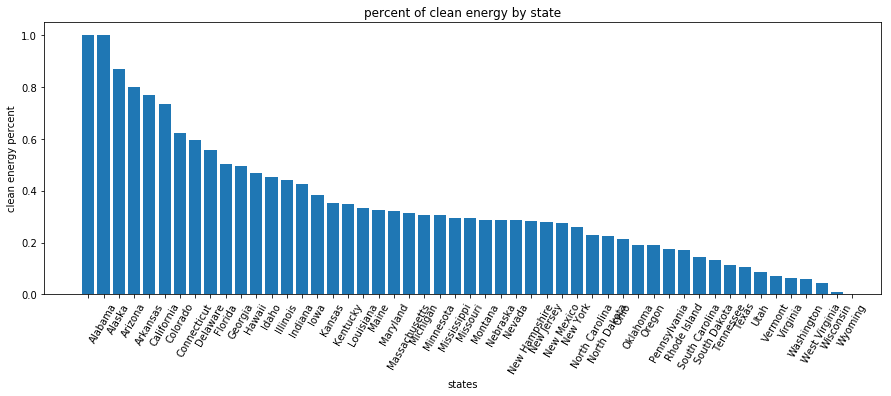

In [162]:
# plots by percent of clean energy
sorted_clean_percent = power_production_by_state['clean_percent'].sort_values(ascending=False)

plt.figure(figsize=(15,5))
plt.title('percent of clean energy by state'.format())
plt.xticks(rotation=60)
plt.xlabel('states')
plt.ylabel('clean energy percent')
plt.bar(power_production_by_state.index, sorted_clean_percent)

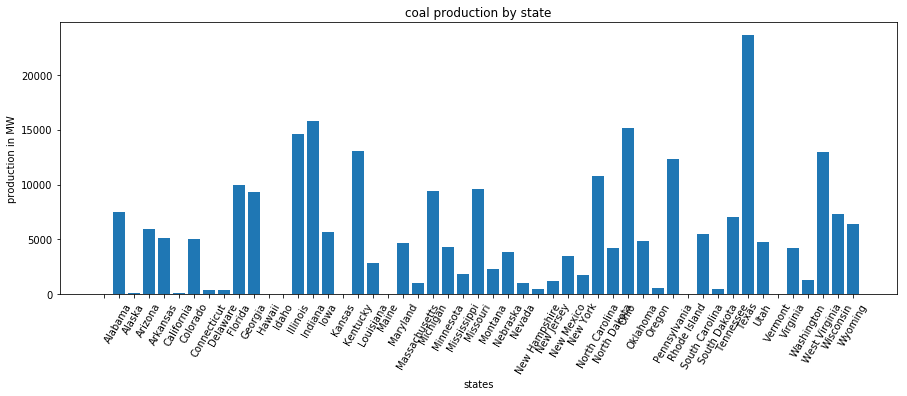

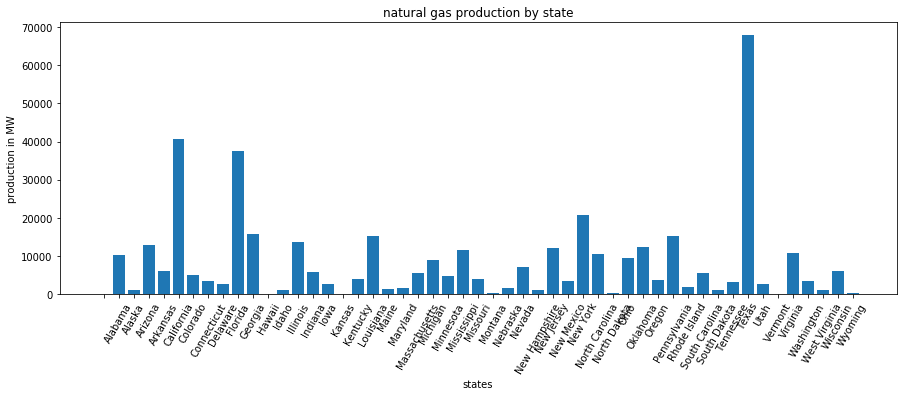

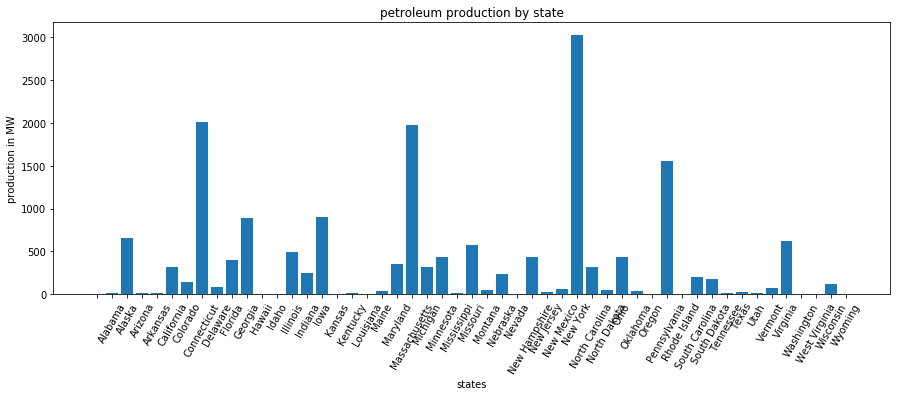

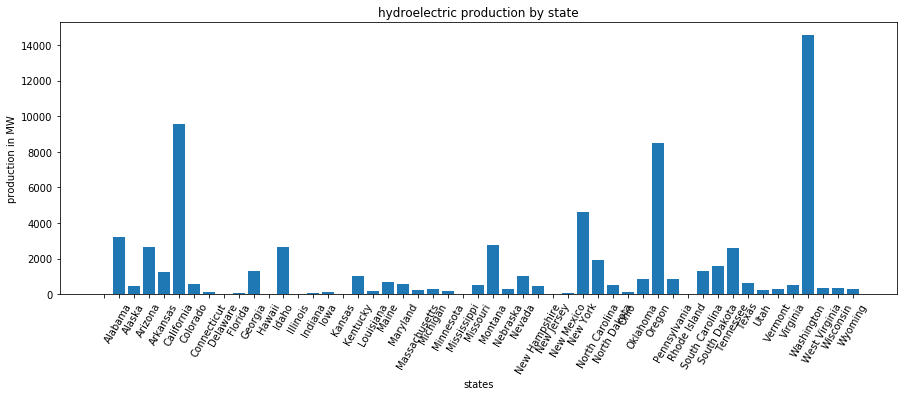

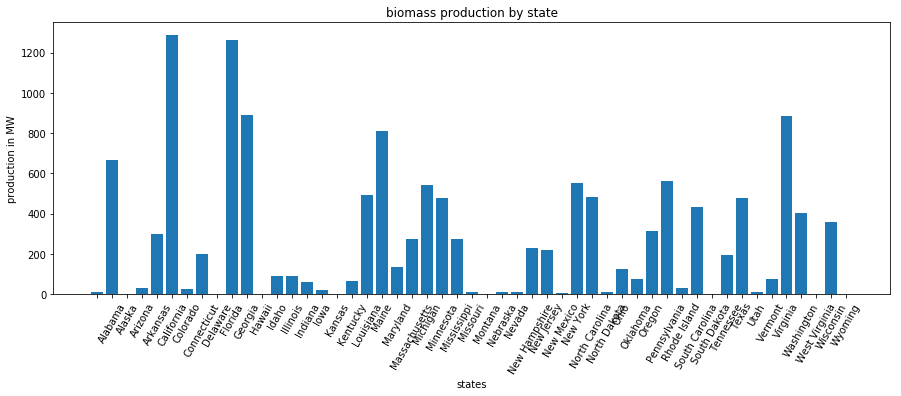

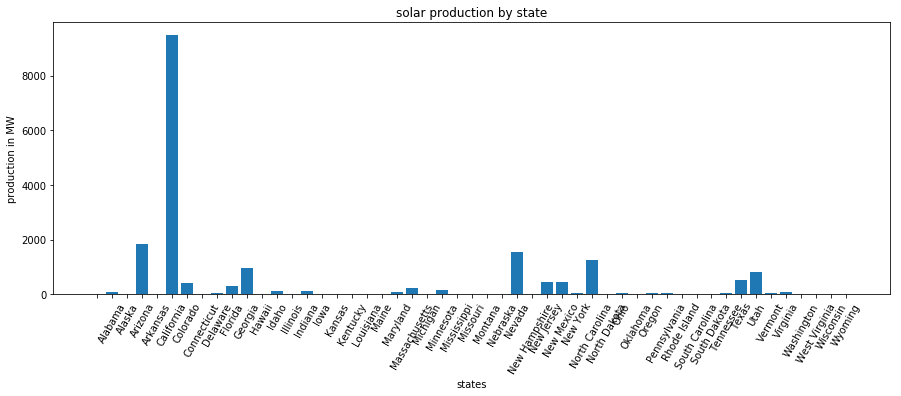

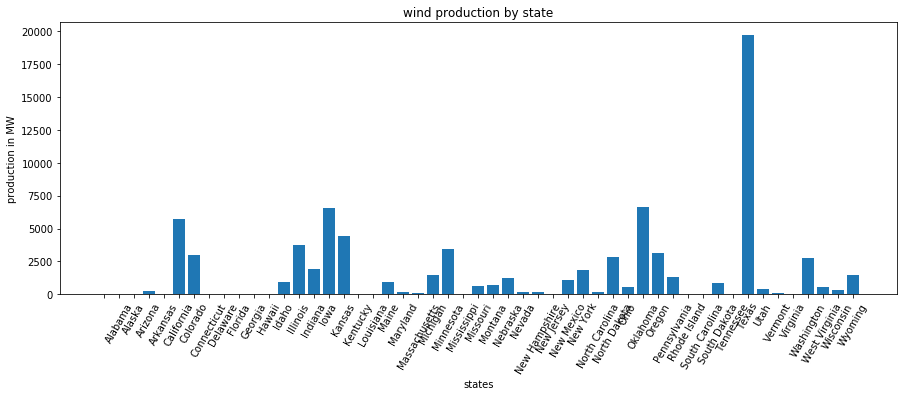

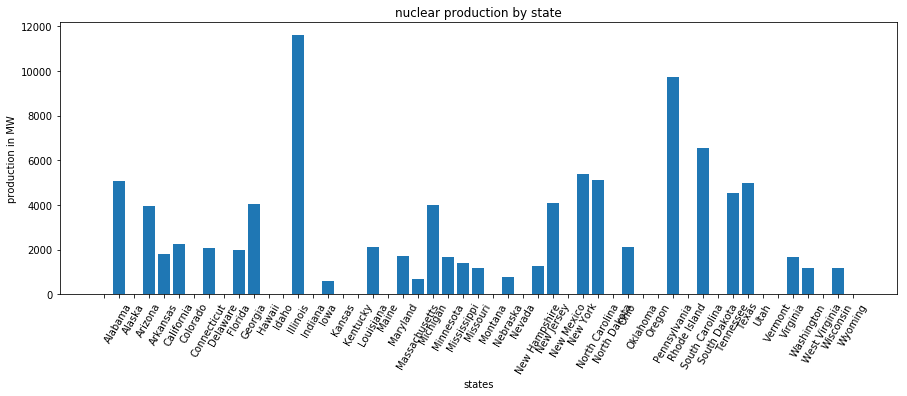

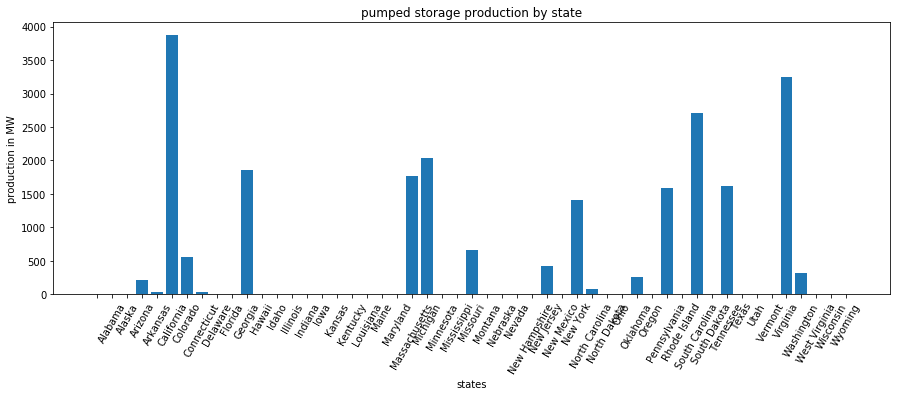

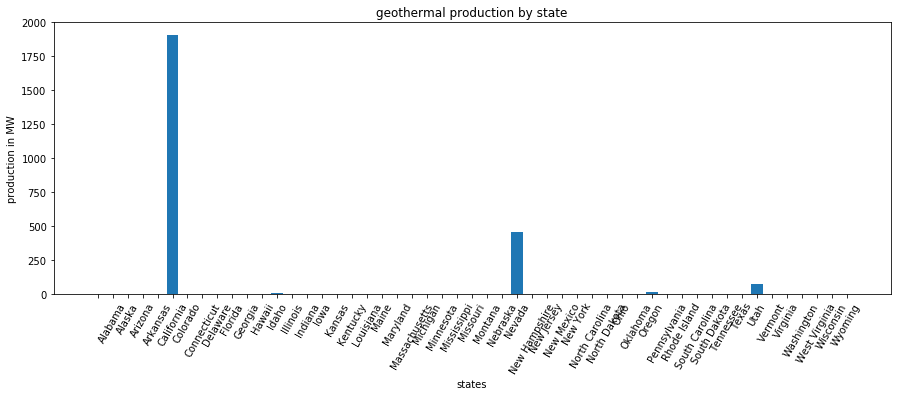

In [163]:
#plots for energy source breakdown
for source in energy_sources:
    plt.figure(figsize=(15,5))
    plt.title('{} production by state'.format(source))
    plt.xticks(rotation=60)
    plt.xlabel('states')
    plt.ylabel('production in MW')
    plt.bar(power_production_by_state.index, power_production_by_state[source])

# Air Quality

In [164]:
chemicals = ['TSO4','TNH4','CA','MG','NA','K','CL','NSO4','NHNO3', 'WSO2', 'WNO3', 'total_SO2', 'total_NO3']

In [165]:
air_df = pd.read_csv(air_data_path)
air_df = air_df[air_df['county'].isin(overlap_counties)]
air_df.head()

,latitude,longitude,state_code,county,date_on,date_off,TSO4,TNH4,CA,MG,NA,K,CL,NSO4,NHNO3,WSO2,WNO3,total_SO2,total_NO3,flow_volume
0,39.988309,-79.251573,PA,Somerset,01/03/2000 16:37:00,01/10/2000 16:03:00,2.3406,0.7764,0.1267,0.0144,0.1740,0.0536,NaN,0.4753,1.1347,10.2084,0.5588,10.5254,1.8930,14.9233
1,39.988309,-79.251573,PA,Somerset,01/10/2000 16:09:00,01/17/2000 19:57:00,1.7681,0.9436,0.2127,0.0272,0.1700,0.0452,NaN,1.2391,1.3881,16.4770,0.4621,17.3035,2.3097,14.9819
2,39.988309,-79.251573,PA,Somerset,01/17/2000 20:07:00,01/24/2000 21:00:00,3.7462,0.9171,0.1410,0.0220,0.1805,0.0534,NaN,1.5380,3.2918,31.8606,0.8644,32.8865,4.1565,14.5267
3,39.988309,-79.251573,PA,Somerset,01/24/2000 21:11:00,01/31/2000 16:33:00,3.6490,1.4580,0.1359,0.0217,0.3100,0.0534,NaN,1.9024,3.1171,26.0389,1.0820,27.3078,4.5255,13.8887
4,39.988309,-79.251573,PA,Somerset,01/31/2000 16:40:00,02/07/2000 16:06:00,3.8717,0.8672,0.0944,0.0146,0.1143,0.0391,NaN,2.3108,4.8706,28.7423,0.7741,30.2836,5.6604,14.6524


In [166]:
air_df.shape

(68391, 20)

In [167]:
air_df[['date_on']] = pd.to_datetime(air_df['date_on'])
air_df[['date_off']] = pd.to_datetime(air_df['date_off'])
air_df.head()

,latitude,longitude,state_code,county,date_on,date_off,TSO4,TNH4,CA,MG,NA,K,CL,NSO4,NHNO3,WSO2,WNO3,total_SO2,total_NO3,flow_volume
0,39.988309,-79.251573,PA,Somerset,2000-01-03 16:37:00,2000-01-10 16:03:00,2.3406,0.7764,0.1267,0.0144,0.1740,0.0536,NaN,0.4753,1.1347,10.2084,0.5588,10.5254,1.8930,14.9233
1,39.988309,-79.251573,PA,Somerset,2000-01-10 16:09:00,2000-01-17 19:57:00,1.7681,0.9436,0.2127,0.0272,0.1700,0.0452,NaN,1.2391,1.3881,16.4770,0.4621,17.3035,2.3097,14.9819
2,39.988309,-79.251573,PA,Somerset,2000-01-17 20:07:00,2000-01-24 21:00:00,3.7462,0.9171,0.1410,0.0220,0.1805,0.0534,NaN,1.5380,3.2918,31.8606,0.8644,32.8865,4.1565,14.5267
3,39.988309,-79.251573,PA,Somerset,2000-01-24 21:11:00,2000-01-31 16:33:00,3.6490,1.4580,0.1359,0.0217,0.3100,0.0534,NaN,1.9024,3.1171,26.0389,1.0820,27.3078,4.5255,13.8887
4,39.988309,-79.251573,PA,Somerset,2000-01-31 16:40:00,2000-02-07 16:06:00,3.8717,0.8672,0.0944,0.0146,0.1143,0.0391,NaN,2.3108,4.8706,28.7423,0.7741,30.2836,5.6604,14.6524


In [168]:
air_df['year'] = air_df['date_off'].map(lambda x: x.year)
air_2018 = air_df[air_df['year'] == 2018]

In [169]:
air_qual_by_county = air_2018.groupby('county').mean()
air_qual_by_county = air_qual_by_county.drop(['WNO3', 'latitude', 'longitude', 'year'], axis=1)
air_qual_by_county.head()

,TSO4,TNH4,CA,MG,NA,K,CL,NSO4,NHNO3,WSO2,total_SO2,total_NO3,flow_volume
county,,,,,,,,,,,,,
Adair,1.256914,0.867693,0.367798,0.048511,0.171086,0.092881,0.068868,0.226605,0.688189,0.302093,0.453236,1.544950,15.051098
Adams,1.221014,1.017339,0.191543,0.037455,0.133207,0.067836,0.099655,0.317191,0.873470,0.521643,0.733202,1.876925,14.848327
Albany,0.310073,0.158032,0.108485,0.017624,0.027256,0.030102,0.013102,0.043266,0.244293,0.116617,0.145473,0.398459,40.678783
Aroostook,0.510555,0.209793,0.078864,0.022859,0.082120,0.073595,0.078409,0.145925,0.177375,0.191591,0.288914,0.384341,14.523930
Beltrami,0.567227,0.593114,0.250023,0.061516,0.047552,0.048589,0.045123,0.112202,0.305125,0.199459,0.274291,0.893389,28.737595


In [170]:
air_qual_by_county.shape

(67, 13)

# Merge Datasets

In [173]:
pp_counties = set(pp_df['county'].unique())
air_counties = set(air_df['county'].unique())
overlap_counties = pp_counties & air_counties

# filter by overlapping counties
pp_filtered = pp_df[pp_df['county'].isin(overlap_counties)]
air_filtered = air_2018[air_2018['county'].isin(overlap_counties)]

In [184]:
pp_by_county = pp_filtered.groupby('county').sum()
get_green_proportions(pp_by_county)
pp_by_county.head()

,longitude,latitude,coal,natural gas,petroleum,hydroelectric,biomass,solar,wind,nuclear,pumped storage,geothermal,total_energy,dirty_total,clean_total,clean_percent,dirty_percent
county,,,,,,,,,,,,,,,,,
Adair,-1320.716030,577.843484,0.0,13.0,5.5,0.0,0.0,0.0,288.9,0.0,0.0,0.0,307.4,18.5,288.9,0.939818,0.060182
Adams,-2381.655452,1022.337533,3569.0,1217.2,95.8,22.1,8.3,17.0,259.3,0.0,0.0,0.0,5188.7,4882.0,306.7,0.059109,0.940891
Albany,-1236.263729,636.022950,0.0,1116.2,0.0,49.7,10.7,1.7,154.1,0.0,0.0,0.0,1332.4,1116.2,216.2,0.162264,0.837736
Aroostook,-544.855261,373.483003,0.0,0.0,4.2,2.2,66.0,0.0,190.0,0.0,0.0,0.0,262.4,4.2,258.2,0.983994,0.016006
Beltrami,-95.129652,47.544582,0.0,41.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.9,41.9,0.0,0.000000,1.000000


In [186]:
air_by_county = air_filtered.groupby('county').mean()
air_by_county.head()

,latitude,longitude,TSO4,TNH4,CA,MG,NA,K,CL,NSO4,NHNO3,WSO2,WNO3,total_SO2,total_NO3,flow_volume,year
county,,,,,,,,,,,,,,,,,
Adair,35.750786,-94.669789,1.256914,0.867693,0.367798,0.048511,0.171086,0.092881,0.068868,0.226605,0.688189,0.302093,NaN,0.453236,1.544950,15.051098,2018
Adams,39.923241,-77.307863,1.221014,1.017339,0.191543,0.037455,0.133207,0.067836,0.099655,0.317191,0.873470,0.521643,NaN,0.733202,1.876925,14.848327,2018
Albany,41.364531,-106.240020,0.310073,0.158032,0.108485,0.017624,0.027256,0.030102,0.013102,0.043266,0.244293,0.116617,NaN,0.145473,0.398459,40.678783,2018
Aroostook,46.603832,-68.413227,0.510555,0.209793,0.078864,0.022859,0.082120,0.073595,0.078409,0.145925,0.177375,0.191591,NaN,0.288914,0.384341,14.523930,2018
Beltrami,47.863800,-94.835200,0.567227,0.593114,0.250023,0.061516,0.047552,0.048589,0.045123,0.112202,0.305125,0.199459,NaN,0.274291,0.893389,28.737595,2018


In [199]:
merged = pp_by_county.merge(air_by_county, left_index=True, right_index=True)
merged = merged.drop(['longitude_x', 'latitude_x', 'year', 'WNO3'], axis=1)
merged.head()

,coal,natural gas,petroleum,hydroelectric,biomass,solar,wind,nuclear,pumped storage,geothermal,...,MG,NA,K,CL,NSO4,NHNO3,WSO2,total_SO2,total_NO3,flow_volume
county,,,,,,,,,,,,,,,,,,,,,
Adair,0.0,13.0,5.5,0.0,0.0,0.0,288.9,0.0,0.0,0.0,...,0.048511,0.171086,0.092881,0.068868,0.226605,0.688189,0.302093,0.453236,1.544950,15.051098
Adams,3569.0,1217.2,95.8,22.1,8.3,17.0,259.3,0.0,0.0,0.0,...,0.037455,0.133207,0.067836,0.099655,0.317191,0.873470,0.521643,0.733202,1.876925,14.848327
Albany,0.0,1116.2,0.0,49.7,10.7,1.7,154.1,0.0,0.0,0.0,...,0.017624,0.027256,0.030102,0.013102,0.043266,0.244293,0.116617,0.145473,0.398459,40.678783
Aroostook,0.0,0.0,4.2,2.2,66.0,0.0,190.0,0.0,0.0,0.0,...,0.022859,0.082120,0.073595,0.078409,0.145925,0.177375,0.191591,0.288914,0.384341,14.523930
Beltrami,0.0,41.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.061516,0.047552,0.048589,0.045123,0.112202,0.305125,0.199459,0.274291,0.893389,28.737595


# Modeling - county-wise

In [350]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [351]:
filtered_chemicals = ['TSO4','TNH4','CA','MG','NA','K','CL','NSO4','NHNO3', 'WSO2', 'total_SO2', 'total_NO3']

In [352]:
merged = merged.reset_index()

In [353]:
x_data = merged[energy_sources]
y_data = merged[filtered_chemicals]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=.15)
model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

print("MSE: {}".format(mean_squared_error(y_test, y_pred)))
print("R^2 Score: {}".format(model.score(x_test, y_test)))

MSE: 0.07507807710772896
R^2 Score: -0.3496845641914572


In [354]:
modeling_pipeline(merged)

MSE: 0.10629472887483976
R^2 Score: -0.16253803229255753


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

# Modeling - powerplant-wise

In [355]:
pp_merged = pp_filtered.merge(air_by_county, on='county', right_index=True, how='right')
pp_merged = pp_merged.drop(['longitude_x', 'latitude_x', 'longitude_y', 'latitude_y', 'year', 'WNO3'], axis=1)
pp_merged = pp_merged.reset_index()
pp_merged.shape

(914, 34)

In [356]:
pp_merged.columns

Index(['index', 'primary_source', 'plant_name', 'city', 'county', 'state_name',
       'coal', 'natural gas', 'petroleum', 'hydroelectric', 'biomass', 'solar',
       'wind', 'nuclear', 'pumped storage', 'geothermal', 'total_energy',
       'dirty_total', 'clean_total', 'clean_percent', 'dirty_percent', 'TSO4',
       'TNH4', 'CA', 'MG', 'NA', 'K', 'CL', 'NSO4', 'NHNO3', 'WSO2',
       'total_SO2', 'total_NO3', 'flow_volume'],
      dtype='object')

In [357]:
x_data = pp_merged[energy_sources]
y_data = pp_merged[filtered_chemicals]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=.15)
model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

print("MSE: {}".format(mean_squared_error(y_test, y_pred)))
print("R^2 Score: {}".format(model.score(x_test, y_test)))

MSE: 0.06731782992055464
R^2 Score: -0.0046413040000928005


# Metrics

In [340]:
import statsmodels.api as sm

In [344]:

x2 = sm.add_constant(x_data)
est = sm.OLS(y_data, x2)
est2 = est.fit()
print(est2.summary())

KeyError: 0

In [329]:
pd.read_csv('../data/population_data.csv')

,state_name,1970,1971,1972,1973,1974,1975,1976,1977,1978,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Alabama,3444354.0,3497000.0,3540000.0,3581000.0,3628000.0,3680000.0,3737000.0,3783000.0,3834000.0,...,4708708.0,4785448,4798834,4815564,4830460,4842481,4853160,4864745,4875120,4887871
1,Alaska,302583.0,316000.0,326000.0,333000.0,345000.0,371000.0,393000.0,397000.0,402000.0,...,698473.0,713906,722038,730399,737045,736307,737547,741504,739786,737438
2,Arizona,1775399.0,1896000.0,2009000.0,2125000.0,2224000.0,2286000.0,2348000.0,2427000.0,2518000.0,...,6595778.0,6407774,6473497,6556629,6634999,6733840,6833596,6945452,7048876,7171646
3,Arkansas,1923322.0,1972000.0,2018000.0,2058000.0,2100000.0,2158000.0,2169000.0,2207000.0,2241000.0,...,2889450.0,2921978,2940407,2952109,2959549,2967726,2978407,2990410,3002997,3013825
4,California,19971071.0,20346000.0,20585000.0,20868000.0,21173000.0,21537000.0,21934000.0,22350000.0,22839000.0,...,36961664.0,37320903,37641823,37960782,38280824,38625139,38953142,39209127,39399349,39557045
5,Colorado,2209596.0,2303000.0,2405000.0,2496000.0,2541000.0,2586000.0,2632000.0,2696000.0,2767000.0,...,5024748.0,5048281,5121771,5193721,5270482,5351218,5452107,5540921,5615902,5695564
6,Connecticut,3032217.0,3061000.0,3070000.0,3069000.0,3076000.0,3085000.0,3086000.0,3089000.0,3095000.0,...,3518288.0,3579125,3588023,3594395,3594915,3594783,3587509,3578674,3573880,3572665
7,Delaware,548104.0,565000.0,574000.0,579000.0,583000.0,589000.0,593000.0,595000.0,598000.0,...,885122.0,899595,907316,915188,923638,932596,941413,949216,957078,967171
8,Florida,6791418.0,7163000.0,7520000.0,7927000.0,8317000.0,8542000.0,8695000.0,8889000.0,9132000.0,...,18537969.0,18845785,19093352,19326230,19563166,19860330,20224249,20629982,20976812,21299325
9,Georgia,4587930.0,4710000.0,4807000.0,4907000.0,4995000.0,5058000.0,5126000.0,5212000.0,5286000.0,...,9829211.0,9711810,9801578,9901496,9973326,10069001,10181111,10304763,10413055,10519475


In [ ]:
lambda x: []